# Practical Optimisations for Pandas 🐼
## Eyal Trabelsi

# About Me 🙈


- Software Engineer at Salesforce 👷

- Big passion for python, data and performance optimisations 🐍🤖

- Online at [medium](https://medium.com/@Eyaltra) | [twitter](https://twitter.com/eyaltra) 🌐

# What's Pandas?🐼


- Library for data manipulation

- Dataset on Memory

- Widely used 

# Performance?! Why ?🤨

- Fast is better than slow 🐇


- Memory efficiency is good 💾


- Saving money is awesome [💸](https://aws.amazon.com/ec2/pricing/on-demand/)


- Hardware will only take you so far 💻

![](https://vignette.wikia.nocookie.net/memepediadankmemes/images/8/80/Acb.jpg/revision/latest/scale-to-width-down/340?cb=20180822064733)

- Ok now that i have got you attention, the next question i want to tackle is when should we optimize our code

# When ⏰

- since program readability is our top priority, as python aim to make the programmer life easier, we should only optimize our code when needed.

- so  in other words All optimization are premature.
- unless


- Program doesn't meet requirements 🚔


- wheter its too slow for the user
- or whether its take too much memory

- Program execution affects development pace 👷

- [Only bottlenecks](https://www.youtube.com/watch?v=DUCMjsrYSrQ)

- We should only optimize the program bottlenecks
- whether memory and execution time in order to be productive
- There is a great talk about how it can be done using profiling and the link is provieded

- [Well Tested](https://www.youtube.com/watch?v=ARKbfWk4Xyw)

- Like every refactoring task, you want to have same behaviour and return the same restult.
- The best way to feel safe while refactoring is  by writting tests

![](https://i.redd.it/8ku1ygqwuuj11.jpg)

- altough people mostly think the problem lays in python realms its not actually the case and i will show it to you today

![](https://i.chzbgr.com/full/9093474560/hA8EAB03B/panda-darth-panda-finds-your-lack-of-faith-disturbing-wckpemecom)

- so hopefully now that i have gained your trust 
- we can tackle  The one milion dollar question.
- how can we optimize our pandas code.


# Dataset 📉

In [60]:
! pip install numba numexpr

In [6]:
import math
import time
import warnings
from dateutil.parser import parse

import janitor
import numpy as np
import pandas as pd
from numba import jit
from sklearn import datasets
from pandas.api.types import is_datetime64_any_dtype as is_datetime

In [7]:
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
pd.options.display.max_columns = 999

In [8]:
path = 'https://raw.githubusercontent.com/FBosler/you-datascientist/master/invoices.csv'

def load_dataset(naivly=False):
    df = (pd.concat([pd.read_csv(path)
                       .clean_names()
                       .remove_columns(["meal_id", "company_id"]) 
                     for i in range(20)])
            .assign(meal_tip=lambda x: x.meal_price.map(lambda x: x * 0.2))
            .astype({"meal_price": int})
            .rename(columns={"meal_price": "meal_price_with_tip"}))

    if naivly:
        for col in df.columns:
            df[col] = df[col].astype(object)
    return df

In [9]:
df = load_dataset()
df.head()

,order_id,date,date_of_meal,participants,meal_price,type_of_meal,heroes_adjustment,meal_tip
0,839FKFW2LLX4LMBB,2016-05-27,2016-05-31 07:00:00+02:00,['David Bishop'],469,Breakfast,False,93.8
1,97OX39BGVMHODLJM,2018-09-27,2018-10-01 20:00:00+02:00,['David Bishop'],22,Dinner,False,4.4
2,041ORQM5OIHTIU6L,2014-08-24,2014-08-23 14:00:00+02:00,['Karen Stansell'],314,Lunch,False,62.8
3,YT796QI18WNGZ7ZJ,2014-04-12,2014-04-07 21:00:00+02:00,['Addie Patino'],438,Dinner,False,87.6
4,6YLROQT27B6HRF4E,2015-07-28,2015-07-27 14:00:00+02:00,['Addie Patino' 'Susan Guerrero'],690,Lunch,False,138.0


- Our dataset is a row 1m data that contain meal invoices
- Before i begin its important to state that all these optimization depends on the size of your data and for small dataset these optimizations might be irelevant


# How 👀

# Use What You Need 🧑

- Keep needed columns only

- For many use cases you dont actually need the entire dataset
- There might be unneeded columns which we dont use in our analysis or data manipulation and this can save a lot of memory

- Keep needed rows only

- again For many usecase you dont need all the rows.
- For example if you want to understand the dataset layout you dont need all 1m rows
- this will reduce both your memory footprint and execution time

![](https://i.pinimg.com/originals/66/79/8a/66798a0940a01c4ccc5c2be810d8a678.jpg)

# Dont Reinvent the Wheel 🎡

- Vast ecosystem

- Use existing solutions

- Less bugs

- Highly optimized

- For example instead of implmenting kmeans by your own
- use scipy/sckitlearn implementation, not only you will have less bugs
- but it will probably be highly optimized

![](https://i.imgflip.com/1px0z1.jpg)

# Avoid Loops ♾

- Pandas is design for vector manipulations Which make loops inefficient
- a Rookie mistake in pandas will be to just loop over all the rows" either using iterows or regular iterations

### Bad Option 😈

In [1]:
def iterrows_original_meal_price(df):
    for i, row in df.iterrows():
        df.loc[i]["original_meal_price"] = row["meal_price_with_tip"] - row["meal_tip"]
    return df

In [5]:
%%timeit -r 1 -n 1
iterrows_original_meal_price(df)

35min 13s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


- As you might guessed this bring us  unsatisfied results of half an hour.
- there is a much Nicer way and  it is to use map or apply.

### Better Option 🤵

- apply accepts any user defined function that applies a transformation/aggregation on a DataFrame. 

In [4]:
def apply_original_meal_price(df):
    df["original_meal_price"] = df.apply(lambda x: x['meal_price_with_tip'] - x['meal_tip'], axis=1)
    return df

In [5]:
%%timeit 
apply_original_meal_price(df)

22.5 s ± 170 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


- As we can the performance look better as it took 21 seconds and about 100 times faster then iterows 
- but can we do any better? The obvious answer is yes using vectorization

## 100x Improvement In Execution Time ⌛

## Iterrow is evil 😈

### Best Option 👼

In [65]:
def vectorized_original_meal_price(df):
    df["original_meal_price"] = df["meal_price_with_tip"] - df["meal_tip"] 
    return df

- Vectorization is the process of executing operations on entire arrays.
- Pandas/numpy/scipy includes a generous collection of vectorized functions from mathematical operations to aggregations.

In [66]:
%%timeit 
vectorized_original_meal_price(df)

2.46 ms ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


- We can see the benefit of vetorized function right away we got from  to 2ms and about 100,00.


## Another 8000x Improvement In Execution Time ⌛

## Use Vectorized Operations 😇

# Picking the Right Type 🌈

## Motivation 🏆

In [67]:
ones = np.ones(shape=5000)
ones

array([1., 1., 1., ..., 1., 1., 1.])

In [84]:
types = ['object', 'complex128', 'float64', 'int64', 'int32', 'int16', 'int8', 'bool']
df = pd.DataFrame(dict([(t, ones.astype(t)) for t in types]))
df.memory_usage(index=False, deep=True)

object        160000
complex128     80000
float64        40000
int64          40000
int32          20000
int16          10000
int8            5000
bool            5000
dtype: int64

## Where We Stand 🌈

In [69]:
df = load_dataset(naivly=True)

### Dataframe Size 🏋️

In [70]:
df.memory_usage(deep=True).sum()

478844140

### Columns Sizes 🏋️

In [71]:
df.memory_usage(deep=True)

Index                 8002720
order_id             73024820
date                 67022780
date_of_meal         82027880
participants         84977580
meal_price           36012240
type_of_meal         63688760
heroes_adjustment    32076480
meal_tip             32010880
dtype: int64

In [72]:
df.dtypes

order_id             object
date                 object
date_of_meal         object
participants         object
meal_price           object
type_of_meal         object
heroes_adjustment    object
meal_tip             object
dtype: object

- I hope its clear that the type of the column effect the memory foot print.
- There is a great picture explain

## Supported Types 🌈

- int64 


- float64

- bool

- objects


- datetime64


- timedelta

- [Category](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html)

- The category type is good when the same elements occur over and over again.
- and its New in version 0.23.0.

- [Sparse Types](https://pandas.pydata.org/docs/user_guide/sparse.html)


- The sparse types is good when most of the array includes nulls.
- and its New in version 0.24.0

- [Nullable Integer](https://pandas.pydata.org/docs/user_guide/integer_na.html)/[Nullable Bolean](https://pandas.pydata.org/docs/user_guide/boolean.html)


- The Nullable type is good when element are integer/boolean and includes nulls.
- This is because NaN is a float and it forces the entire array to be cast as float and thus has a bigger memory footprint. 
- and its New in version 0.24.0

so its pretty obvious that we should aim for the type that has lowest memory footprint with the same functionality

## Optimizing Types 🌈

- Loading dataframes with specific types

- Use to_numeric/to_datetime/to_timedelta functions with downcast parameter

In [11]:
df = df.astype({'order_id': 'category',
                'date': 'category',
                'date_of_meal': 'category',
                'participants': 'category',
                'meal_price': 'int16',
                'type_of_meal': 'category',
                'heroes_adjustment': 'bool',
                'meal_tip': 'float32'})

## Optimized Types 🌈

### Dataframe Size 🏋️


In [75]:
df.memory_usage(deep=True).sum()

36999962

### Columns Sizes 🏋️

In [76]:
df.memory_usage(deep=True)

Index                8002720
order_id             8963321
date                 2204942
date_of_meal         3942538
participants         5883450
meal_price           2000680
type_of_meal         1000611
heroes_adjustment    1000340
meal_tip             4001360
dtype: int64

In [77]:
df.dtypes

order_id             category
date                 category
date_of_meal         category
participants         category
meal_price              int16
type_of_meal         category
heroes_adjustment        bool
meal_tip              float32
dtype: object

## 12x Improvement In Memory ⌛

- its important to note that i have loaded the dataframe with very naive types in order to emphasis the change
- but in most use cases you could expect to at least halve the memory foot print

## Types Magic Explanation 🧙


- DataFrame is stored in seperated blocks depending on thier types.


- Under the hood, pandas groups the columns into blocks of values of the same type.


- For blocks representing numeric values like integers and floats, pandas combines the columns and stores them as a NumPy ndarray. Also for extension arrays.

- The NumPy ndarray is built around a C array, and the values are stored in a contiguous block of memory. Due to this storage scheme, accessing a slice of values is incredibly fast.

![](https://www.dataquest.io/wp-content/uploads/2019/01/df_blocks.png)

## Custom Types 🦸🏼🦸‍♀️

- This optimization is for extreme cases as it requires a lot of effort and skills.
- basicly its implementing you own custom types using extension array

- [Your Own Types](https://www.youtube.com/watch?v=xx7H5EkzQH0)

- Open Sourced Types like [cyberpandas](https://github.com/ContinuumIO/cyberpandas) and [geopandas](https://github.com/geopandas/geopandas) 

There are open sourced Types like cyberpandas for ip like objects and geopadnas for spatial like objects


![](https://i.kym-cdn.com/photos/images/facebook/000/549/339/210.jpg)

# Pandas Usage 🐼

## Chunks 🍰

- Splitting large data to smaller parts

- Work with large datasets

In [52]:
def proccess():
    pass

In [53]:
def proccess_file(huge_file_path, chunksize = 10 ** 6):
    for chunk in pd.read_csv(path, chunksize=chunksize):
        process(chunk)    

## Mean/Sum/Mode/Min/etc optimization 🧮


- Types matter

In [32]:
%%timeit
df["meal_price_with_tip"].astype(object).mean()

96 ms ± 499 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
%%timeit
df["meal_price_with_tip"].astype(float).mean()

4.27 ms ± 34.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 20x Performance Improvement⌛

## DataFrame Serialization 🏋


- Various file formats

- Loading time


- Saving time


 - Disk space

![](https://miro.medium.com/max/1356/1*6qdaUz8pMFTurG7N14SQjA.png)

## Query/Eval 🧬

- Use [numexpr](https://pypi.org/project/numexpr/) if installed

- Improve Execution Time 👍

- The expected behaviour is up to 2 time faster

- Improve Memory 👍

- The main benefit of eval/query is the saved memory

- NumPy allocate memory to every itermediate step.

- and this Gives you the ability to compute this type of compound expression element by element, without the need to allocate full intermediate arrays.

- Not all Operations are supported 👎

## Example

In [28]:
%%timeit
df[df.type_of_meal=="Breakfast"]

103 ms ± 348 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%%timeit
df.query("type_of_meal=='Breakfast'")

82.4 ms ± 223 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## % 20 Performance Improvement⌛

## Use on big datasets 🧞

- The pandas API indicate to only use eval on  more than 10,000 rows, as the traditional method is faster for smaller arrays.


## Concat vs Append ➕


- Every append creates a new dataframe object

- Multiple appends are inefficient

- Use concat

## Sorting Optimization 📟

- Vanilla python

- Pandas 

- Numpy

- Pytorch/Tensorflow

![](https://github.com/eyaltrabelsi/my-notebooks/raw/master/Lectures/Sort.png)

## GroupBy Optimizations 👩‍👩‍👧

- Filter early

- Custom functions are slow

- Extract logic for custom functions [when possible](https://medium.com/dunder-data/pandas-challenge-001-optimize-custom-grouping-function-44a9f2f321f8)

## Merge Optimization 🔍

- Filter/Aggregate early

- Semi join

- [Join on index](https://stackoverflow.com/questions/53645882/pandas-merging-101)

# Compiled Code ?! Why 🤯

- Python dynamic nature 

- No compilation optimization

- Pure Python can be slow 

In [17]:
def foo(N):
    accumulator = 0
    for i in range(N):
        accumulator = accumulator + i
    return accumulator

- Cython

- the Cython project which converts Python code to compatiable C code

- Numba

- and the second one the Numba project, which converts Python code to fast LLVM bytecode

In [18]:
%%timeit
df.meal_price_with_tip.map(foo)

17.9 s ± 25.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Cython and Numba for the rescue 👨‍🚒

## Cython 🤯

- Up to 50x speedup from pure python 👍


- Learning Curve 👎

- Separated Compilation Step 👎 👍


- The compilation is both a con and a pro
- on one hand, there is an additional work to integrate the cython code 
- and on the other hand, there is no compilation overhead on runtime

In [19]:
%load_ext Cython

## Example 

In [20]:
%%cython
def cython_foo(long N):
    cdef long accumulator
    accumulator = 0

    cdef long i
    for i in range(N):
        accumulator += i

    return accumulator

In [21]:
%%timeit
df.meal_price_with_tip.map(cython_foo)

365 ms ± 2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 49x  Performance Improvement⌛

## Numba 🤯

- Up to 200x speedup from pure python  👍


- Easy 👍


using numba is really easy its simply adding a decorator to a method

- Highly Configurable  👍

- Debugging 👎 👍

- Debugging is both a con and a pro
- on one hand, debugging the buissness logic is easy we can just remove the decorator and then we debug it as python code
- on the other hand, if there is an issue in the compiled code itself its not quite easy to debug these issues.

- Mostly Numeric 👎 

## Example 

In [22]:
@jit(nopython=True)
def numba_foo(N):
    accumulator = 0
    for i in range(N):
        accumulator = accumulator + i
    return accumulator

In [23]:
%%timeit
df.meal_price_with_tip.map(numba_foo)

414 ms ± 596 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 43x  Performance Improvement⌛

In [ ]:
@jit(nopython=True, parallel=True)
def numba_foo(N):
    accumulator = 0
    for i in range(N):
        accumulator = accumulator + i
    return accumulator

In [ ]:
%%timeit
df.meal_price_with_tip.map(numba_foo)

### 1️⃣ Vectorized methods 

### 2️⃣ Numba 

### 3️⃣ Cython 

# General Python Optimizations 🐍

- Since pandas is writen in python we can optimize our pandas code by using python optimization 

## Caching 🏎


- Avoid unnecessary work/computation.

- Faster code 

## Intermediate Variables👩‍👩‍👧‍👧

- Intermediate calculations 

- Memory foot print of both objects

- Smarter variables allocation 

In [32]:
def another_foo(data):
    return data * 2

def foo(data):
    return data + 10


## Example

In [28]:
%reload_ext memory_profiler

In [37]:
def load_data():
    return np.ones((2 ** 30), dtype=np.uint8)

In [50]:
%%memit
def proccess():
    data = load_data()
    return another_foo(foo(data))

proccess()

peak memory: 8106.62 MiB, increment: 3042.64 MiB


In [51]:
%%memit
def proccess():
    data = load_data()
    data = foo(data)
    data = another_foo(data)
    return data

proccess()

peak memory: 7102.64 MiB, increment: 2038.66 MiB


## Concurrency And Parallelism 🎸🎺🎻🎷

- pandas methods use single process

- CPU bound can benefit parallelism

- IO bound is very bad without parallesim/concurrency

## High Performance Python Book 📖

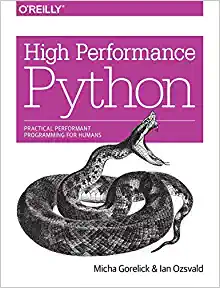

# Pandas Alternatives 🐨🐻

- Libraries that provide dataframe apis

- [modin](https://www.youtube.com/watch?v=-HjLd_3ahCw)

- [cudf](https://www.youtube.com/watch?v=lV7rtDW94do) 

- [pyspark](http://spark.apache.org/docs/latest/api/python/index.html)

- **No free lunch** 🥢


fillna cudf sux , group by cudf best, modin can be bad cudf hard

# How 👀

- Use What You Need 💾⌛

- Dont Reinvent the Wheel ⌛💾

- Avoid Loops ⌛

- Picking the Right Types 💾⌛

- Pandas Usage ⌛💾

- Compiled Code ⌛

- General Python Optimizations ⌛💾

- Pandas Alternatives ⌛💾

# Additional Resources 📚

- [Vectorization Mindset 📖](https://www.youtube.com/watch?v=EEUXKG97YRw)
- [Numpy](https://numpy.org/doc/stable/reference/index.html)/[Pandas](https://pandas.pydata.org/pandas-docs/stable/index.html)/[Scipy](https://docs.scipy.org/doc/scipy/reference/special.html) vectorizations methods 📖
- [Serialization Time](https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d) 📖
- [Chunks](https://pandas.pydata.org/docs/user_guide/scale.html) 📖
- [Sorting](https://towardsdatascience.com/surprising-sorting-tips-for-data-scientists-9c360776d7e)📖
- [Caching](https://medium.com/datadriveninvestor/all-things-caching-use-cases-benefits-strategies-choosing-a-caching-technology-exploring-fa6c1f2e93aa) 📖
- [Numba Workshop](https://www.youtube.com/watch?v=1AwG0T4gaO0) 🛠
- [Cython Workshop](https://www.youtube.com/watch?v=FepqwPI6U80)🛠
- [Numba VS C++](https://murillogroupmsu.com/numba-versus-c/) ⚖
- [Cython VS C](https://notes-on-cython.readthedocs.io/en/latest/std_dev.html) ⚖
- [Intermediate Variables](https://pythonspeed.com/articles/function-calls-prevent-garbage-collection/) 📖
- [High Performance Python Book ](https://amzn.to/38CKsuU) 📖
- [Pandas Alternatives](https://www.youtube.com/watch?v=RRtqIagk93k) 📖

![](https://i.pinimg.com/originals/b9/0a/79/b90a79b4c361d079144597d0bcdd61de.jpg)